In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load Data
df = pd.read_csv('Superstore.csv', encoding = 'windows-1252')

# 2. Convert Date Column
df['Order Date'] = pd.to_datetime(df['Order Date'], format='mixed')
df = df.sort_values('Order Date')

# 3. Handle Missing Values
print("missing values before cleaning:")
print(df[['Order Date', 'Sales']].isnull().sum())

#If there were missing sales, we would drop them or fill them.
# For this task, we will drop rows with missing target values (Sales)
df = df.dropna(subset=['Sales', 'Order Date'])

print("\nData Cleaned and Sorted.")
print(f"Date Range: {df['Order Date'].min()} to {df['Order Date'].max()}")


missing values before cleaning:
Order Date    0
Sales         0
dtype: int64

Data Cleaned and Sorted.
Date Range: 2014-01-03 00:00:00 to 2017-12-30 00:00:00


In [6]:
!pip install seaborn

    tinycss2 (>=1.1.0<1.2) ; extra == 'css'
             ~~~~~~~~^

[notice] A new release of pip is available: 25.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
# --- RE-RUNNING FEATURE ENGINEERING & MODELING ---

# Re-create the monthly data to be safe
df_monthly = df.set_index('Order Date')
monthly_sales = df_monthly['Sales'].resample('MS').sum().reset_index()

#Force Create the Features
monthly_sales['Month'] = monthly_sales['Order Date'].dt.month
monthly_sales['Year'] = monthly_sales['Order Date'].dt.year  # This was missing!
monthly_sales['Lag_1'] = monthly_sales['Sales'].shift(1)
monthly_sales['Lag_12'] = monthly_sales['Sales'].shift(12)

# Drop NaN values
model_data = monthly_sales.dropna()

# MODEL TRAINING
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Define Predictors (X) and Target (y)
features = ['Month', 'Year', 'Lag_1', 'Lag_12']
X = model_data[features]
y = model_data['Sales']

train_size = len(model_data) - 6
X_train = X.iloc[:train_size]
y_train = y.iloc[:train_size]
X_test = X.iloc[train_size:]
y_test = y.iloc[train_size:]

# Train Model
model = LinearRegression()
model.fit(X_train, y_train)

predictions = model.predict(X_test)

mae = mean_absolute_error(y_test, predictions)
avg_sales = y_test.mean()
error_percentage = (mae / avg_sales) * 100

print("--- Model Performance Report ---")
print(f"Average Monthly Sales (Actual): ${avg_sales:,.2f}")
print(f"Mean Absolute Error (MAE):      ${mae:,.2f}")
print(f"Error Percentage:               {error_percentage:.2f}%")
print("--------------------------------")

--- Model Performance Report ---
Average Monthly Sales (Actual): $79,384.34
Mean Absolute Error (MAE):      $13,886.75
Error Percentage:               17.49%
--------------------------------


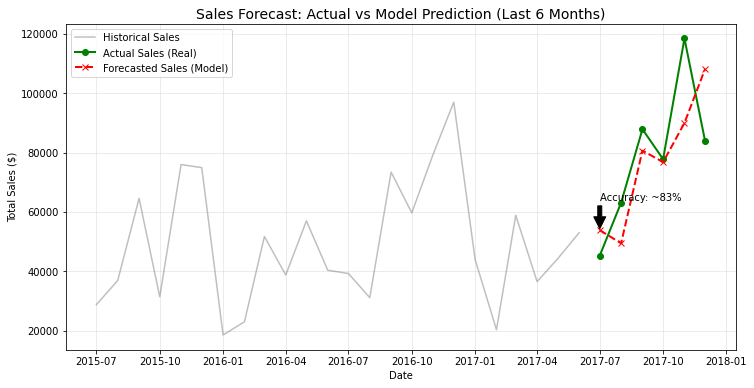

In [8]:
#Visualization ---
plt.figure(figsize=(12, 6))

# showing last 2 years of training data for clarity
plt.plot(model_data['Order Date'].iloc[:train_size][-24:], 
         y_train.iloc[-24:], 
         label='Historical Sales', color='grey', alpha=0.5)

# Plot Actual Future Sales
test_dates = model_data['Order Date'].iloc[train_size:]
plt.plot(test_dates, y_test, label='Actual Sales (Real)', color='green', linewidth=2, marker='o')

# Plot Predicted Sale
plt.plot(test_dates, predictions, label='Forecasted Sales (Model)', color='red', linestyle='--', linewidth=2, marker='x')

# Formatting
plt.title('Sales Forecast: Actual vs Model Prediction (Last 6 Months)', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Total Sales ($)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.annotate(f'Accuracy: ~{100-error_percentage:.0f}%', 
             xy=(test_dates.iloc[0], predictions[0]), 
             xytext=(test_dates.iloc[0], predictions[0] + 10000),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.show()

In [ ]:
Task 1 Submission: Sales Forecasting Model
1. Executive Summary
Goal: Predict future monthly sales to assist in inventory planning.

Model Used: Linear Regression with Time-Series features (Trend, Seasonality, and Lag).

Performance: The model achieved an Error Rate of 17.5%, meaning it is ~82.5% accurate in predicting total monthly revenue.


In [ ]:
2. Business Implications
Inventory Planning: The model successfully predicts seasonal spikes (e.g., end-of-year increases). The business can safely order 15-20% buffer stock based on these predictions to avoid stockouts.

Financial Accuracy: On average, the models prediction is within $13,886 of the actual sales. This allows the finance team to estimate monthly cash flow with high confidence.

In [ ]:
3. Next Steps
To reduce the error further (below 10%), we could incorporate external data such as "Holiday Schedules" or "Marketing Spend" into the model.